Developed this as a reference and proof of concept. This was further improved together.

In [81]:
import matplotlib.animation as animation
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import networkx as nx

import numpy as np

In [82]:
prob_meet_new = 0.7 # Modelled as uniform through the whole graph for now
prob_infect_on_meet = 0.5
prob_recover = 0.3

Initial graph stuff

In [83]:
num_iter = 100
prob_inf_init = 0.02

In [84]:
N = 200
K = 5
DENSITY1 = 0.05
DENSITY2 = 0.001

### Generate population graph

In [85]:
clusters = [list(range(i, N, K)) for i in range(K)]
status = [int(np.random.random() < prob_inf_init) for _ in range(N)]
adj = [set() for _ in range(N)]

# connect each cluster internally - kinda dumb way, but whatever
for nodes in clusters:
    for a, b in zip(nodes, nodes[1:]):
        adj[a].add(b); adj[b].add(a)

# backbone between successive clusters
for i in range(K - 1):
    a, b = clusters[i][0], clusters[i + 1][0]
    adj[a].add(b); adj[b].add(a)

# add extra intra-cluster edges with "probability" DENSITY1
for nodes in clusters:
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            u, v = nodes[i], nodes[j]
            if v not in adj[u] and np.random.random() < DENSITY1:
                adj[u].add(v); adj[v].add(u)

# add extra inter-cluster edges with "probability" DENSITY2
for c1 in range(K):
    for c2 in range(c1 + 1, K):
        for u in clusters[c1]:
            for v in clusters[c2]:
                if v not in adj[u] and np.random.random() < DENSITY2:
                    adj[u].add(v); adj[v].add(u)

# connectivity check
visited, stack = set(), [0]
while stack:
    n = stack.pop()
    if n in visited:
        continue
    visited.add(n)
    stack.extend(adj[n] - visited)

print("Total edges:", sum(len(neigh) for neigh in adj) // 2)
print("Connected:", len(visited) == N)


Total edges: 396
Connected: True


In [ ]:
statuses = [status.copy()]

for iter in range(num_iter):
    new_status = status.copy()

    for node in range(N):
        if status[node] != 1: continue

        if np.random.uniform() < prob_recover:
            new_status[node] = 2

        for neigh in adj[node]:
            if status[neigh]: continue
            if np.random.uniform() > prob_meet_new: continue
            if np.random.uniform() > prob_infect_on_meet: continue

            new_status[neigh] = 1

    statuses.append(new_status.copy())
    status = new_status

## Plot

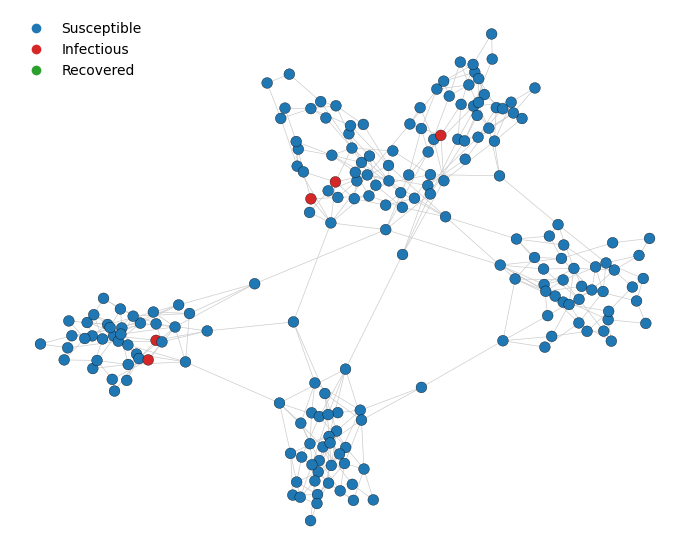

In [87]:
def plot_force(adj,
               statuses=None,
               node_size=60,
               iterations=1000,
               seed=1):
    N = len(adj)
    if statuses is None:
        statuses = np.zeros(N, dtype=int)
    else:
        statuses = np.asarray(statuses)
        if statuses.shape != (N,):
            raise ValueError("statuses must be a 1-D array of length N")

    # build NetworkX graph
    G = nx.Graph()
    G.add_nodes_from(range(N))
    for u in range(N):
        G.add_edges_from((u, v) for v in adj[u] if v > u)

    # spring layout
    pos = nx.spring_layout(G, iterations=iterations, seed=seed)

    # colour map
    palette = {0: "#1f77b4", 1: "#d62728", 2: "#2ca02c"}
    colours = [palette.get(s, "#7f7f7f") for s in statuses]

    # draw
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_aspect("equal")
    ax.axis("off")

    for u, v in G.edges:
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        ax.plot([x1, x2], [y1, y2], lw=0.5, color="#cccccc")

    xy = np.array([pos[i] for i in range(N)])
    ax.scatter(xy[:, 0], xy[:, 1],
               s=node_size, c=colours,
               edgecolors="k", linewidths=0.25, zorder=3)

    # legend
    handles = [Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=palette[k], markersize=8, label=l)
               for k, l in enumerate(["Susceptible", "Infectious", "Recovered"])]
    ax.legend(handles=handles, frameon=False, loc="upper left")

    plt.tight_layout()
    plt.show()

plot_force(adj, statuses[0])

In [ ]:
def animate_force(adj,
                  statuses,
                  node_size=60,
                  iterations=1000,
                  seed=1,
                  fps=4,
                  outfile="epidemic.gif"):
    N = len(adj)
    G = nx.Graph()
    G.add_nodes_from(range(N))
    for u in range(N):
        G.add_edges_from((u, v) for v in adj[u] if v > u)

    # compute positions only once
    pos = nx.spring_layout(G, iterations=iterations, seed=seed)

    palette = {0: "#1f77b4", 1: "#d62728", 2: "#2ca02c"}

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_aspect("equal")
    ax.axis("off")

    # draw static edges once
    for u, v in G.edges:
        x1, y1 = pos[u];  x2, y2 = pos[v]
        ax.plot([x1, x2], [y1, y2], lw=0.5, color="#cccccc", zorder=1)

    # initial scatter
    xy = np.array([pos[i] for i in range(N)])
    face_colours = [palette[s] for s in statuses[0]]
    scat = ax.scatter(xy[:, 0], xy[:, 1],
                      s=node_size,
                      c=face_colours,
                      edgecolors="k",
                      linewidths=0.25,
                      zorder=3)

    # legend - draw once
    from matplotlib.lines import Line2D
    handles = [Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=palette[k], markersize=8,
                      label=l)
               for k, l in enumerate(["Susceptible", "Infectious", "Recovered"])]
    ax.legend(handles=handles, frameon=False, loc="upper left")

    # animation callback
    def update(frame):
        new_cols = [palette[s] for s in statuses[frame]]
        scat.set_facecolors(new_cols)
        return scat,

    ani = animation.FuncAnimation(fig,
                                  update,
                                  frames=len(statuses),
                                  blit=True,
                                  repeat=False)

    ani.save(outfile, writer="pillow", fps=fps)
    plt.close(fig)

    print(f"Saved animation to: {outfile}")

# animate time
animate_force(adj, statuses, fps=4, outfile="epidemic.gif")


Saved animation to: epidemic.gif
